In [1]:
from torchvision import models
import torch

import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
import matplotlib.pyplot as plt
from itertools import cycle


resnet34_pretrained = models.resnet34(pretrained=True)

print(resnet34_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
num_classes= 18
num_ftrs = resnet34_pretrained.fc.in_features
resnet34_pretrained.fc = nn.Linear(num_ftrs, num_classes)

In [3]:
class TrainDataset(Dataset):
    def __init__(self, img_paths, transform, json_data):
        self.img_paths = img_paths
        self.transform = transform
        self.json_data = json_data
        
    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        label = json_data[index//7]['img'][index%7]['class']
        
        return image, label

    def __len__(self):
        return len(self.img_paths)

In [4]:
import json
with open("train.json", "r") as f:
    json_data = json.load(f)
json_data = json_data['train']

In [5]:
# image_paths = []
# for image in json_data:
#     for img in image['img']:
#         print(img['path'])
#         image_paths.append(img['path'])

In [6]:
# image_paths[:10]
path_dir = 'input/data/train/images'

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = []
for image in json_data:
    for img in image['img']:
        image_paths.append(img['path'])

In [7]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    transforms.RandomHorizontalFlip(0.5),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
train_dataset = TrainDataset(image_paths, transform, json_data)

In [8]:
from sklearn.model_selection import StratifiedKFold

img = []
label = []
for i in train_dataset:
    img.append(list(i))
    label.append(i[1])

In [9]:
import pandas
df = pandas.DataFrame(img)

In [10]:
skfold = StratifiedKFold(n_splits=5)

In [11]:
n_iter = 0
for train_index, test_index in skfold.split(df,df[1]):
    n_iter += 1
    label_train = df[1].iloc[train_index]
    label_test = df[1].iloc[test_index]
    print('## 교차 검증: {0}'.format(n_iter))
    print('학습 레이블 데이터 분포:\n', label_train.value_counts())
    print('검증 레이블 데이터 분포:\n', label_test.value_counts())

## 교차 검증: 1
학습 레이블 데이터 분포:
 4     3268
3     2928
0     2196
1     1640
10     654
16     653
9      586
15     585
6      439
12     439
5      436
2      332
13     328
7      328
11      88
17      87
14      67
8       66
Name: 1, dtype: int64
검증 레이블 데이터 분포:
 4     817
3     732
0     549
1     410
16    164
10    163
15    147
9     146
12    110
6     110
5     109
2      83
7      82
13     82
17     22
11     21
8      17
14     16
Name: 1, dtype: int64
## 교차 검증: 2
학습 레이블 데이터 분포:
 4     3268
3     2928
0     2196
1     1640
10     654
16     653
9      586
15     586
6      439
12     439
5      436
2      332
13     328
7      328
11      87
17      87
14      67
8       66
Name: 1, dtype: int64
검증 레이블 데이터 분포:
 4     817
3     732
0     549
1     410
16    164
10    163
9     146
15    146
12    110
6     110
5     109
2      83
7      82
13     82
11     22
17     22
8      17
14     16
Name: 1, dtype: int64
## 교차 검증: 3
학습 레이블 데이터 분포:
 4     3268
3     2928
0     2196
1     1

In [37]:
n_iter = 0
for train_index, test_index in skfold.split(df,df[1]):
    n_iter += 1
    train_index_list = train_index
    test_index_list = test_index
    if n_iter == 2:
        break
    

In [38]:
class TrainDataset(Dataset):
    def __init__(self, df):
        self.img_paths = df
        
    def __getitem__(self, index):
        image = self.img_paths[0].iloc[index]
        label = self.img_paths[1].iloc[index]
        
        return image, label

    def __len__(self):
        return len(self.img_paths)

In [114]:
age_60_index = []
for i in range(len(train_index_list)):
    try:
        if (df.iloc[train_index_list][1]==5)[i] == True:
            age_60_index.append(i)
        if (df.iloc[train_index_list][1]==2)[i] == True:
            age_60_index.append(i)
        if (df.iloc[train_index_list][1]==13)[i] == True:
            age_60_index.append(i)
        if (df.iloc[train_index_list][1]==7)[i] == True:
            age_60_index.append(i)
        if (df.iloc[train_index_list][1]==17)[i] == True:
            age_60_index.append(i)
        if (df.iloc[train_index_list][1]==11)[i] == True:
            age_60_index.append(i)
        if (df.iloc[train_index_list][1]==14)[i] == True:
            age_60_index.append(i)
        if (df.iloc[train_index_list][1]==8)[i] == True:
            age_60_index.append(i)
            
    except:
        pass

In [115]:
train_dataset = TrainDataset(df.iloc[train_index_list])
loader = DataLoader(train_dataset,batch_size=64,shuffle=True, drop_last=True)

In [116]:
test_data = TrainDataset(df.iloc[test_index_list])
test_loader = DataLoader(test_data,batch_size=64,shuffle=False, drop_last=True)

In [157]:
age_60_dataset = TrainDataset((df.iloc[train_index_list]).iloc[age_60_index])
age_60_loader = DataLoader(age_60_dataset, batch_size=64, shuffle=True, drop_last=True)

In [159]:
len(loader)

236

In [158]:
len(age_60_loader)

19

In [146]:
import numpy as np
import torch

# 중앙을 중심으로 지킬앤 하이드 처럼 좌우에 컷믹스
def rand_bbox(size, lam):
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_h = int(H * cut_rat)


    cy = np.random.randn() + H//2

    # 패치의 4점
    bby1 = 0
    bby2 = 384/2

    return  int(bby1), int(bby2)

In [153]:
inputs[:, :, :, bby1:bby2] = inputs_60[rand_index, :, :, bby1:bby2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


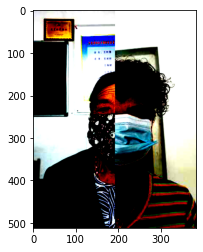

In [154]:
plt.imshow(  (inputs[1].cpu()).permute(1, 2, 0)  )

In [161]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True

In [163]:
import random
import os
seed_everything(999)

In [ ]:

# # meta 데이터와 이미지 경로를 불러옵니다.
# path_dir = 'input/data/train/images'

# # Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.

# transform = transforms.Compose([
#     Resize((512, 384), Image.BILINEAR),
#     transforms.RandomHorizontalFlip(0.5),
#     ToTensor(),
#     Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
# ])

# train_dataset = TrainDataset(image_paths[:18200], transform, json_data[:2600])
# test_dataset = TrainDataset(image_paths[18200:], transform, json_data[2600:])

# loader = DataLoader(
#     train_dataset,
#     batch_size=64, # 
#     shuffle=True # shuffle 추가
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=64,
#     shuffle=False
# )

from sklearn.metrics import f1_score
device = torch.device('cuda')
model = resnet34_pretrained.to(device)
model.train()

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

for epoch in range(20):
    running_loss = 0.0
    n_iter = 0
    epoch_f1 = 0
    for (i, data), (j, data_60) in zip(enumerate(loader, 0),cycle(enumerate(age_60_loader, 0))):
        n_iter += 1
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        inputs_60, labels_60 = data_60
        inputs_60 = inputs_60.to(device)
        labels_60 = labels_60.to(device)

        
        # t_ = torch.zeros((100,18))
        # t_[range(100),labels]=1
        # print(t_)
        # t_ = t_.to(device)
        
        optimizer.zero_grad()
        
        if np.random.random() > 0.8 :
            rand_index = torch.randperm(inputs_60.size()[0]) # 패치에 사용할 label
            target_a = labels # 원본 이미지 label
            target_b = labels_60[rand_index] # 패치 이미지 label  
#             lam = np.random.beta(1.0, 1.0)     
#             bby1, bby2 = rand_bbox(inputs_60.size(), lam)

                # 원본 데이터에 컷믹스 패치
            inputs[:, :, :, 0:192] = inputs_60[rand_index, :, :, 0:192]
                # 원본 이미지와 패치 이미지의 넓이 비율
            lam = 0.5
                # 예측은 레이블 1개
            outputs = model(inputs)

                # 원본 이미지의 레이블과 패치 이미지의 레이블에 대해 loss 가중합
            loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
            
            # 컷믹스 안하면 그냥 별거 없음
        else:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_f1 += f1_score(preds.cpu().numpy(), labels.cpu().numpy(), average='macro')
        if i % 100 == 0:
            epoch_f1_2 = 0
            print('{},{:.5f} loss: {:.3f}'.format(epoch+1, i+1, running_loss/100))
            with torch.no_grad():
                for (j, data) in enumerate(test_loader, 0):
                    val_inputs, val_labels = data
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
        
                    val_outputs = model(val_inputs)
                    _, val_preds = torch.max(val_outputs, 1)
                    epoch_f1_2 += f1_score(val_preds.cpu().numpy(), val_labels.cpu().numpy(), average='macro')
                print('train_f1:{:.4f}'.format(epoch_f1/n_iter))
                print('val_f1:{:.4f}'.format(epoch_f1_2/j))
                    

    print('Finished')
   

torch.save(model.state_dict(), '/opt/ml/test_resnet_base_iter_cutmix.pt')

1,1.00000 loss: 0.015
train_f1:0.0503
val_f1:0.7535
1,101.00000 loss: 0.348
train_f1:0.7374
val_f1:0.7533
1,201.00000 loss: 0.559
train_f1:0.7895
val_f1:0.7527
Finished
2,1.00000 loss: 0.001
train_f1:0.9853
val_f1:0.7476
2,101.00000 loss: 0.248
train_f1:0.8069
val_f1:0.7669
2,201.00000 loss: 0.526


In [ ]:
        test_inputs, test_labels = data2
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_preds = torch.max(test_outputs, 1)
        
        epoch_f1_2 += f1_score(test_preds.cpu().numpy(), test_labels.cpu().numpy(), average='macro')
        print('test_f1:{:.4f}'.format(epoch_f1_2))

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir = '/opt/ml/input/data/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'batch_64_RANDOM_epoch_50_resnet_34_eval_iter2.csv'), index=False)

print('test inference is done!')